## Load the Packages

In [1]:

import os, cv2, random
import numpy as np
import pandas as pd
import keras
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, precision_score, recall_score
from tqdm import tqdm
import matplotlib.pyplot as plt

from tensorflow.keras.applications import ResNet50
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
from tensorflow.keras.utils import plot_model, model_to_dot
from IPython.display import SVG

import shutil
from sklearn.model_selection import train_test_split
import os

original_train_dir = "data/train" 
TRAIN_DIR = "data/train_split"
VAL_DIR = "data/val_split"
TEST_DIR = "data/test1"
categories = ["cat", "dog"]

for folder in [TRAIN_DIR, VAL_DIR]:
    for category in categories:
        os.makedirs(os.path.join(folder, category), exist_ok=True)

for category in categories:
    files = [f for f in os.listdir(original_train_dir) if f.startswith(category)]
    train_files, val_files = train_test_split(files, test_size=0.5, random_state=42)
    
    for f in train_files:
        shutil.copy(os.path.join(original_train_dir, f), os.path.join(TRAIN_DIR, category, f))
    for f in val_files:
        shutil.copy(os.path.join(original_train_dir, f), os.path.join(VAL_DIR, category, f))


2026-01-10 10:38:45.782097: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


## Parameters



In [2]:
TEST_SIZE = 0.5
RANDOM_STATE = 2018
BATCH_SIZE = 64
NO_EPOCHS = 5
NUM_CLASSES = 2
IMG_SIZE = 224

## Read the Data


In [3]:
def load_data_from_folders(folder):
    data = []
    labels = []
    
    for label, class_name in enumerate(["cat", "dog"]):
        class_path = os.path.join(folder, class_name)
        for img in tqdm(os.listdir(class_path)):
            img_path = os.path.join(class_path, img)
            img_array = cv2.imread(img_path)
            img_array = cv2.resize(img_array, (IMG_SIZE, IMG_SIZE))
            data.append(img_array)
            labels.append(label)
    
    return np.array(data), np.array(labels)

X_train, y_train = load_data_from_folders(TRAIN_DIR)
X_val, y_val = load_data_from_folders(VAL_DIR)

X_train = X_train / 255.0
X_val = X_val / 255.0

100%|██████████| 6250/6250 [00:12<00:00, 510.09it/s]


## Model

### Prepare the model


In [4]:
model = Sequential()
model.add(ResNet50(include_top=False, pooling='max', weights='imagenet'))
model.add(Dense(NUM_CLASSES, activation='softmax'))
model.layers[0].trainable = False

### Compile the model

We compile the model, using an **adam** optimized, the loss function as **categorical crossentropy** and the metric **accuracy**.

In [5]:
model.compile(optimizer='adam', loss='sparse_categorical_crossentropy', metrics=['accuracy'])

## Model summary

We plot the model description. We can see that the **ResNet-50** model represent the 1st layer of our model, of type **Model**.

In [6]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ resnet50 (Functional)           │ (None, 2048)           │    23,587,712 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 2)              │         4,098 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 23,591,810 (90.00 MB)

 Trainable params: 4,098 (16.01 KB)

 Non-trainable params: 23,587,712 (89.98 MB)

## Train the Model

In [8]:
train_model = model.fit(X_train, y_train,
                  batch_size=BATCH_SIZE,
                  epochs=NO_EPOCHS,
                  verbose=1,
                  validation_data=(X_val, y_val))

Epoch 1/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1602s 8s/step - accuracy: 0.5624 - loss: 0.7217 - val_accuracy: 0.6306 - val_loss: 0.6381
Epoch 2/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 16071s 82s/step - accuracy: 0.6413 - loss: 0.6250 - val_accuracy: 0.6680 - val_loss: 0.6091
Epoch 3/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 1195s 6s/step - accuracy: 0.6565 - loss: 0.6162 - val_accuracy: 0.6072 - val_loss: 0.6720
Epoch 4/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 966s 5s/step - accuracy: 0.6776 - loss: 0.5976 - val_accuracy: 0.6686 - val_loss: 0.6040
Epoch 5/5
196/196 ━━━━━━━━━━━━━━━━━━━━ 968s 5s/step - accuracy: 0.6783 - loss: 0.5997 - val_accuracy: 0.6767 - val_loss: 0.5963


## Validation Accuracy and Loss

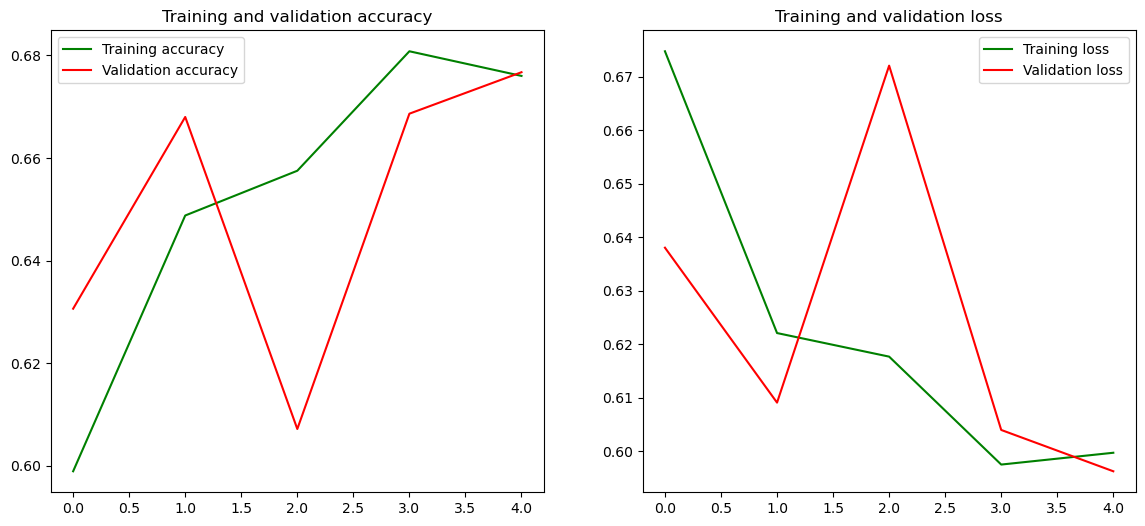

In [9]:
def plot_accuracy_and_loss(train_model):
    hist = train_model.history
    acc = hist['accuracy']
    val_acc = hist['val_accuracy']
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = range(len(acc))
    f, ax = plt.subplots(1,2, figsize=(14,6))
    ax[0].plot(epochs, acc, 'g', label='Training accuracy')
    ax[0].plot(epochs, val_acc, 'r', label='Validation accuracy')
    ax[0].set_title('Training and validation accuracy')
    ax[0].legend()
    ax[1].plot(epochs, loss, 'g', label='Training loss')
    ax[1].plot(epochs, val_loss, 'r', label='Validation loss')
    ax[1].set_title('Training and validation loss')
    ax[1].legend()
    plt.show()
plot_accuracy_and_loss(train_model)

Let's also show the numeric validation accuracy and loss.

In [10]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Validation loss:', score[0])
print('Validation accuracy:', score[1])

Validation loss: 0.596299946308136
Validation accuracy: 0.6767200231552124


## Validation Accuracy

In [11]:
y_pred = np.argmax(model.predict(X_val), axis=1)
y_true = y_val

391/391 ━━━━━━━━━━━━━━━━━━━━ 529s 1s/step


We create two indices, **correct** and **incorrect**, for the images in the validation set with class predicted correctly and incorrectly, respectively.

In [12]:
predicted_classes = np.argmax(model.predict(X_val), axis=1)
correct = np.nonzero(predicted_classes==y_true)[0]
incorrect = np.nonzero(predicted_classes!=y_true)[0]

391/391 ━━━━━━━━━━━━━━━━━━━━ 551s 1s/step


In [13]:
target_names = ["Class {}:".format(i) for i in range(NUM_CLASSES)]
print(classification_report(y_true, predicted_classes, target_names=target_names))

              precision    recall  f1-score   support

    Class 0:       0.63      0.84      0.72      6250
    Class 1:       0.76      0.51      0.61      6250

    accuracy                           0.68     12500
   macro avg       0.70      0.68      0.67     12500
weighted avg       0.70      0.68      0.67     12500



## Precision and Recall

In [14]:
y_pred = np.argmax(model.predict(X_val), axis=1)

precision = precision_score(y_val, y_pred)
recall = recall_score(y_val, y_pred)

print("Precision:", precision)
print("Recall:", recall)

391/391 ━━━━━━━━━━━━━━━━━━━━ 534s 1s/step
Precision: 0.7617918938136999
Recall: 0.51424


## Show Test Images With Predicted Class



### Test data prediction

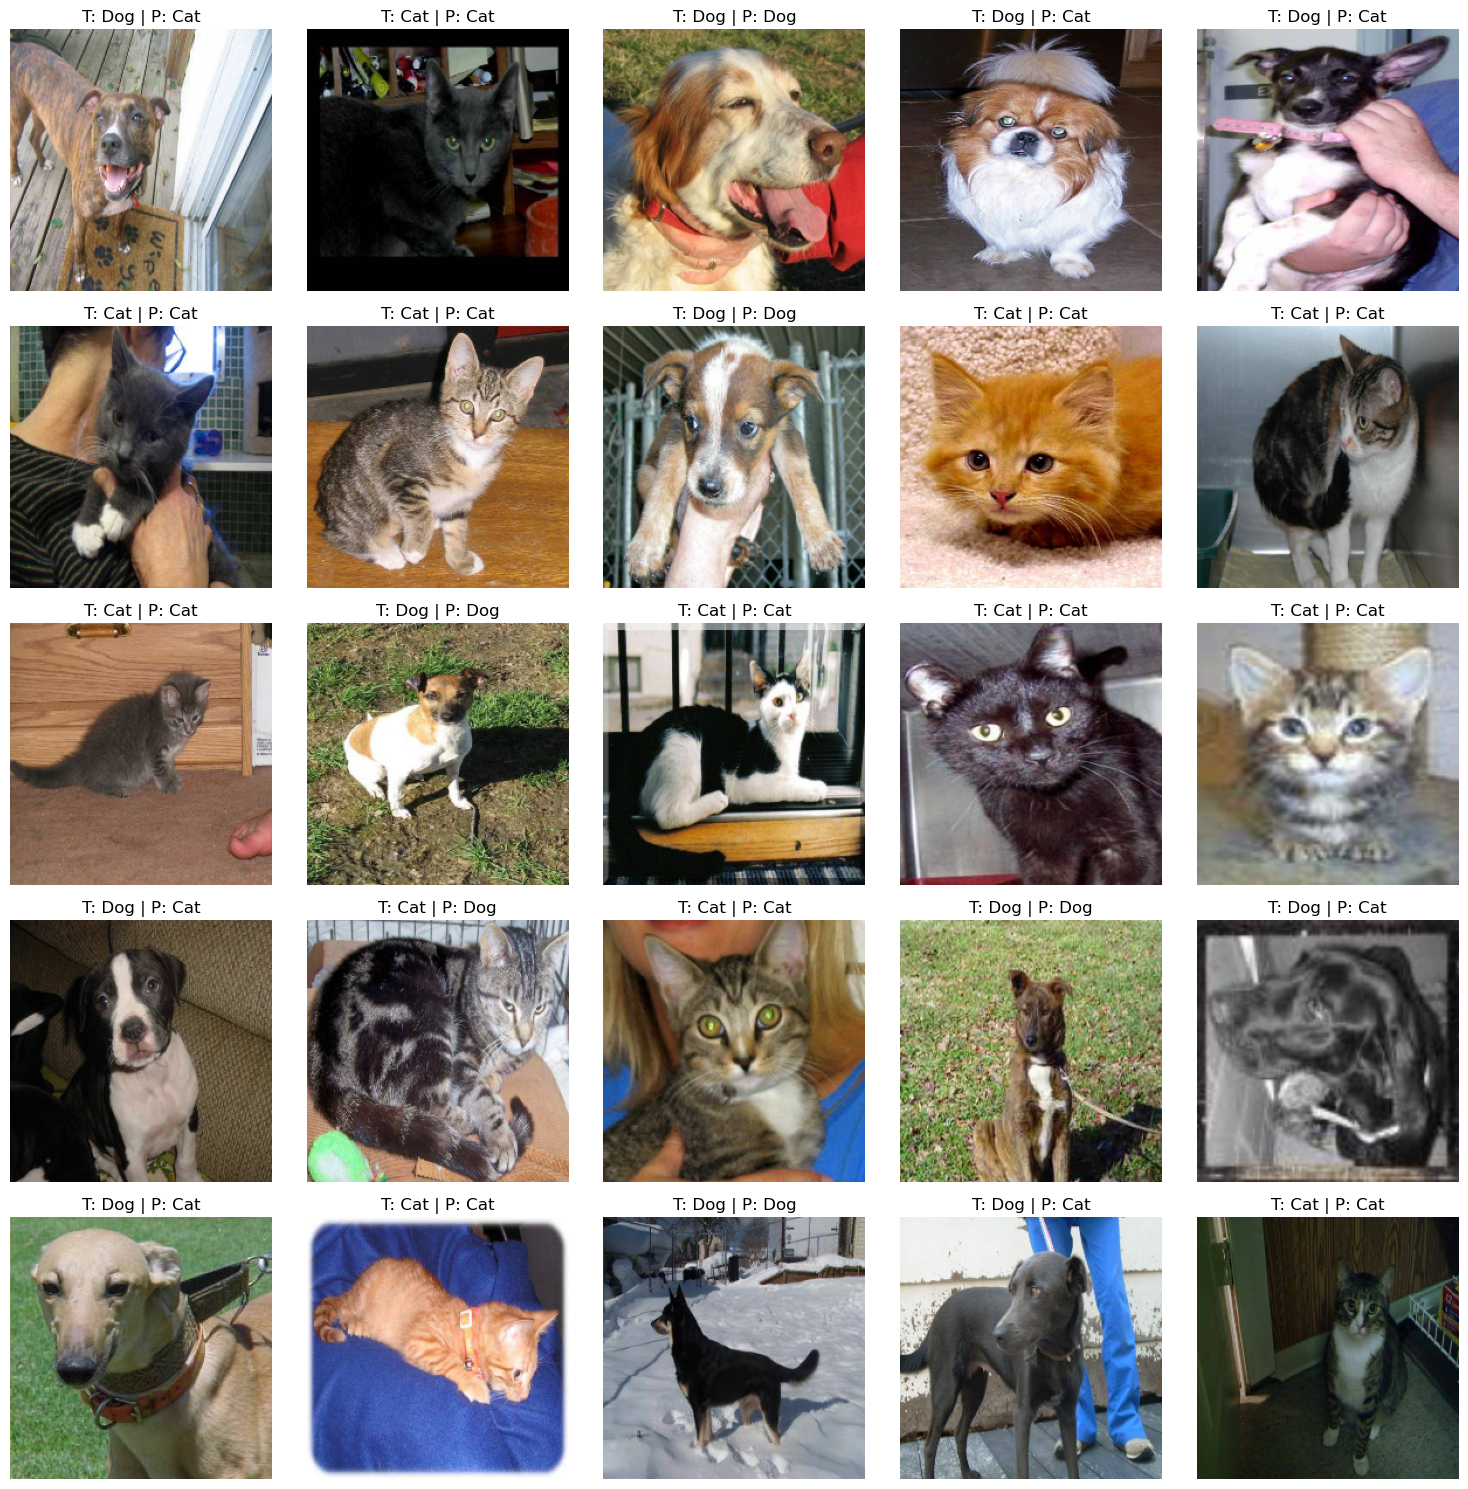

In [16]:
num_images = 25
indices = random.sample(range(len(X_val)), num_images)

plt.figure(figsize=(15, 15))
for i, idx in enumerate(indices):
    img = X_val[idx]
    true_label = y_val[idx]

    pred = model.predict(img.reshape(1, IMG_SIZE, IMG_SIZE, 3), verbose=0)
    pred_label = np.argmax(pred)

    plt.subplot(5, 5, i + 1)
    img_uint8 = (img * 255).astype(np.uint8)
    plt.imshow(cv2.cvtColor(img_uint8, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.title(f"T: {'Dog' if true_label==1 else 'Cat'} | P: {'Dog' if pred_label==1 else 'Cat'}")

plt.tight_layout()
plt.show()
